In [36]:
# Import required libraries
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from wordcloud import STOPWORDS
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer


from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



import time
import datetime
import random

torch.cuda.empty_cache()


In [4]:
# Using GPU for training
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1650 with Max-Q Design


**1. Load and parse**

In [5]:
# Load the dataset into a pandas dataframe
data=pd.read_csv("https://raw.githubusercontent.com/kintis/VKR/main/train.csv", usecols=['text','target'])

# Set pandas configuration
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
data.sample(10, random_state=13)



Number of training sentences: 7,613



,text,target
3738,Morganite Gemstone White Fire Opal 925 Sterling Silver Ring Size 6 R1354 http://t.co/hHpVSAtQXN http://t.co/D12r8XpShy,0
4809,need to work in an office I can bang all my fav Future jams out loud,0
7600,Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,1
1361,@kshllcenterpri1 @Progress4Ohio burning down buildings what you mean like when you burnt down those black churches?,1
2773,Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Db...,0
6268,The Secrets Of The Storm Vortex The Lightning Catcher Book Û_ : http://t.co/OIyWrzL79Z .,0
1063,Hiroshima prepares to remember the day the bomb dropped http://t.co/oJHCGZXLSt,1
4142,Vanderbilt: First Do No Harm http://t.co/cCdx7CGlQW,0
5312,#News Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires'... ht...,1
2512,i decided to take a break from my emotional destruction to watch tangled then watch desolation of smaug,0


In [6]:
# 5 sentences are labeled as disaster
data.loc[data.target == 1].sample(5)[['text', 'target']]

,text,target
7321,Wild land fires.. Here I come. ??????,1
5950,@camilacabello97 Internally and externally screaming,1
3853,@TadhgTGMTEL dude was just smoking and the fucking thing went up in flames i though a bomb went off omg scared,1
1744,South Sac Florin Rd / Franklin Blvd **Trfc Collision-1141 Enrt** http://t.co/Es1b3lywAy,1
163,#OMG! I don't believe this. #RIP bro\n#AirPlane #Accident #JetEngine #TurboJet #Boing #G90 http://t.co/KXxnSZp6nk,1


In [7]:
# 5 sentences are labeled as not disaster
data.loc[data.target == 0].sample(5)[['text', 'target']]

,text,target
5839,If I can't ruin his mood then I may have lost my direction. https://t.co/sLc27EMUgM,0
3927,85V-265V 10W LED Warm White Light Motion Sensor Outdoor Flood Light PIR Lamp AUC http://t.co/NJVPXzMj5V http://t.co/...,0
940,Vanessa's game has officially blown up. LADIES AND GENTLEMEN...the real show is about to begin. #BB17,0
4491,everyone's wonder who will win and I'm over here wondering are those grapes real ?????? #BB17,0
5820,ChinaÛªs stock market crash this summer has sparked interest from bargain hunters and bulls betting on a rebound. D...,0


In [8]:
# Splitting the Data
TRAIN_SIZE=0.8
# Splits Dataset into Training and Testing set
train, test = train_test_split(data, test_size=1-TRAIN_SIZE,
                                         random_state=13) 
print("Train Data size:", len(train))
print("Test Data size", len(test))

print(train.shape)
print(test.shape)

Train Data size: 6090
Test Data size 1523
(6090, 2)
(1523, 2)


**Text normalization**

In [45]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


In [46]:
# Substitution of Contractions
# Dictionary of contractions

contractions_url = 'https://raw.githubusercontent.com/kintis/VKR/main/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [47]:
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


In [48]:
# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


In [49]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


In [50]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://www.kaggle.com/c/nlp-getting-started/overview"> Natural Language Processing with Disaster Tweets </a>'

print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://www.kaggle.com/c/nlp-getting-started/overview"> Natural Language Processing with Disaster Tweets </a>
Output:  Natural Language Processing with Disaster Tweets 


In [51]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [52]:
train["clean_text"] = train["text"].apply(convert_to_lowercase).apply(convert_contractions).apply(remove_emoji).apply(remove_html).apply(remove_whitespace)
test["clean_text"] = test["text"].apply(convert_to_lowercase).apply(convert_contractions).apply(remove_emoji).apply(remove_html).apply(remove_whitespace)


In [53]:
train.sample(5, random_state=13)

,text,target,clean_text
1606,I get this feeling that society will collapse or implode. So don't be a hero and play your part.,0,i get this feeling that society will collapse or implode so do not be a hero and play your part
34,Crying out for more! Set me ablaze,0,crying out for more set me ablaze
1765,my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite http://t.co/Ij...,1,my favorite lady came to our volunteer meeting hopefully joining her youth collision and i am excite http t co ij0wq...
3338,@missleylaha I didn't get to buy one after the last London show because the fire alarm went off and everyone had to ...,0,missleylaha i did not get to buy one after the last london show because the fire alarm went off and everyone had to ...
1309,Flames visible from fire in Tucson mountains: A lightning-caused fire burning in steep rocky terrain in mountainsÛ_...,1,flames visible from fire in tucson mountains a lightning caused fire burning in steep rocky terrain in mountains û_ ...


In [54]:
train_ds=train[['clean_text', 'target']]
test_ds=test[['clean_text', 'target']]


In [55]:
# Get the lists of sentences and their labels
# Train
tweets = train_ds.clean_text.values
labels = train_ds.target.values

# Test
tweets_test = test_ds.clean_text.values
labels_test = test_ds.target.values

**2. Tokenization & Input Formatting**

**2.1. BERT Tokenizer**

In [60]:
# Load the BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading BERT tokenizer...


In [56]:
# Let's apply the tokenizer to one tweet just to see the output
# Print the original tweet
print(' Original: ', tweets[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the tweet mapped to token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  riot kit bah part of the new concept gear coming for autumn winter menswear fashion urbanfashion û_ https t co ccwzdtfbus
Tokenized:  ['riot', 'kit', 'ba', '##h', 'part', 'of', 'the', 'new', 'concept', 'gear', 'coming', 'for', 'autumn', 'winter', 'men', '##sw', '##ear', 'fashion', 'urban', '##fa', '##shi', '##on', 'u', '_', 'https', 't', 'co', 'cc', '##w', '##zd', '##tf', '##bus']
Token IDs:  [11421, 8934, 8670, 2232, 2112, 1997, 1996, 2047, 4145, 6718, 2746, 2005, 7114, 3467, 2273, 26760, 14644, 4827, 3923, 7011, 6182, 2239, 1057, 1035, 16770, 1056, 2522, 10507, 2860, 26494, 24475, 8286]


**2.2. Tokenize Dataset**

In [57]:
# In current cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length
max_len = 0

# For every tweet...
for tweet in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum tweet length
    max_len = max(max_len, len(input_ids))

print("Max tweet's length: ", max_len)

Max tweet's length:  55


Just in case there are some longer test sentences, I'll set the maximum length to 100

In [58]:
# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []

# For every tweet...
for tweet in tweets:
    # `encode_plus` will:
    #   (1) Tokenize the tweet
    #   (2) Prepend the `[CLS]` token to the start
    #   (3) Append the `[SEP]` token to the end
    #   (4) Map tokens to their IDs
    #   (5) Pad or truncate the tweet to `max_length`
    #   (6) Create attention masks for [PAD] tokens
    encoded_dict = tokenizer.encode_plus(
                        tweet,                     # Tweet to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all tweets
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add the encoded tweet to the list    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

c:\Users\Iuliia\miniconda3\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  riot kit bah part of the new concept gear coming for autumn winter menswear fashion urbanfashion û_ https t co ccwzdtfbus
Token IDs: tensor([  101, 11421,  8934,  8670,  2232,  2112,  1997,  1996,  2047,  4145,
         6718,  2746,  2005,  7114,  3467,  2273, 26760, 14644,  4827,  3923,
         7011,  6182,  2239,  1057,  1035, 16770,  1056,  2522, 10507,  2860,
        26494, 24475,  8286,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


**2.3. Training & Validation Split**

In [42]:
# Divide up our training set to use 90% for training and 10% for validation

# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90/10 train/validation split
# Calculate the number of samples to include in each set
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))



5,481 training samples
  609 validation samples


In [25]:
# We'll also create an iterator for our dataset using the torch DataLoader class. 
# This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

# The DataLoader needs to know our batch size for training, so we specify it here. 
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially
            batch_size = batch_size # Evaluate with this batch size
        )

**3. Train Our Classification Model**

**3.1. BertForSequenceClassification**

In [44]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # Binary classification.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

#print(torch.cuda.memory_summary(device=None, abbreviated=False))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [61]:
# In the current cell, I've printed out the names and dimensions of the weights for:
# - The embedding layer.
# - The first of the twelve transformers.
# - The output layer.

params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

**3.2. Optimizer & Learning Rate Scheduler**

For the purposes of fine-tuning, the authors recommend choosing from the following values:<br>

Batch size: 16, 32, 64 ## batch_size=16<br>
Learning rate (Adam): 5e-5, 3e-5, 2e-5<br>
Number of epochs: 2, 3, 4<br>

I chose:<br>

Batch size: 16 (set when creating our DataLoaders)<br>
Learning rate: 6e-6<br>
Epochs:  3<br>
The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation" (from here).<br>



In [29]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


c:\Users\Iuliia\miniconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

1029


**3.3. Training Loop**

Below is our training loop.<br>
Training:<br>
- Unpack our data inputs and labels<br>
- Load data onto the GPU for acceleration<br>
- Clear out the gradients calculated in the previous pass.<br>
  In pytorch the gradients accumulate by default unless you explicitly clear them out.<br>
- Forward pass (feed input data through the network)<br>
- Backward pass (backpropagation)<br>
- Tell the network to update parameters with optimizer.step()<br>
- Track variables for monitoring progress<br>

Evalution:<br>
- Unpack our data inputs and labels<br>
- Load data onto the GPU for acceleration<br>
- Forward pass (feed input data through the network)<br>
- Compute loss on our validation data and track variables for monitoring progress<br>


In [31]:
# Function to calculate accuracy scores
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
# Helper function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:

# This training code is based on the `run_glue.py` script here: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value.
seed_val = 13

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# To store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # TRAINING

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()
    
     # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)  
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids, [1]: attention masks, [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Сlear previously calculated gradients before performing a backward pass. 
        model.zero_grad()  

        # Perform a forward pass (evaluate the model on this training batch).
        # It returns the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        result = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict=True)
        
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"- how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


   
    # VALIDATION
    # After the completion of each training epoch, measure our performance on our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        # `batch` contains three pytorch tensors: [0]: input ids , [1]: attention masks, [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.

            result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)
            
        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
        
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
        
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time)) 

    # Record all statistics from this epoch.
    training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))   



======== Epoch 1 / 3 ========
Training...
  Batch    40  of    343.    Elapsed: 0:00:24.
  Batch    80  of    343.    Elapsed: 0:00:53.
  Batch   120  of    343.    Elapsed: 0:01:26.
  Batch   160  of    343.    Elapsed: 0:02:00.
  Batch   200  of    343.    Elapsed: 0:02:33.
  Batch   240  of    343.    Elapsed: 0:03:07.
  Batch   280  of    343.    Elapsed: 0:03:40.
  Batch   320  of    343.    Elapsed: 0:04:14.

  Average training loss: 0.49
  Training epcoh took: 0:04:33

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.39
  Validation took: 0:00:12

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    343.    Elapsed: 0:00:34.
  Batch    80  of    343.    Elapsed: 0:01:08.
  Batch   120  of    343.    Elapsed: 0:01:43.
  Batch   160  of    343.    Elapsed: 0:02:17.
  Batch   200  of    343.    Elapsed: 0:02:54.
  Batch   240  of    343.    Elapsed: 0:03:32.
  Batch   280  of    343.    Elapsed: 0:04:07.
  Batch   320  of    343.    Elapsed: 0:04:41.

  Averag

In [34]:
# Let's view the summary of the training process.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
display(df_stats)




,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.39,0.83,0:04:33,0:00:12
2,0.37,0.37,0.84,0:05:00,0:00:12
3,0.34,0.38,0.84,0:05:11,0:00:14


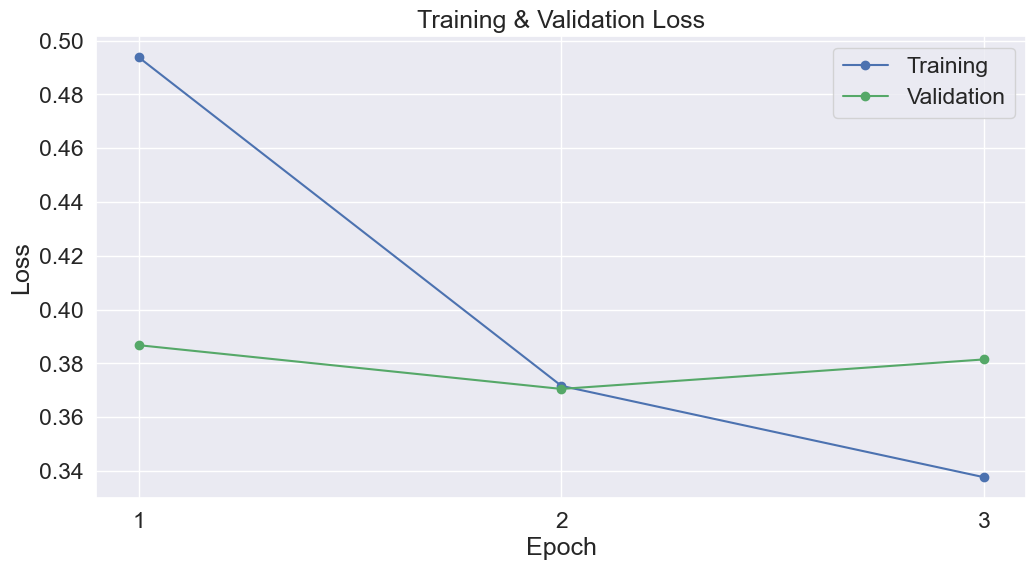

In [88]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

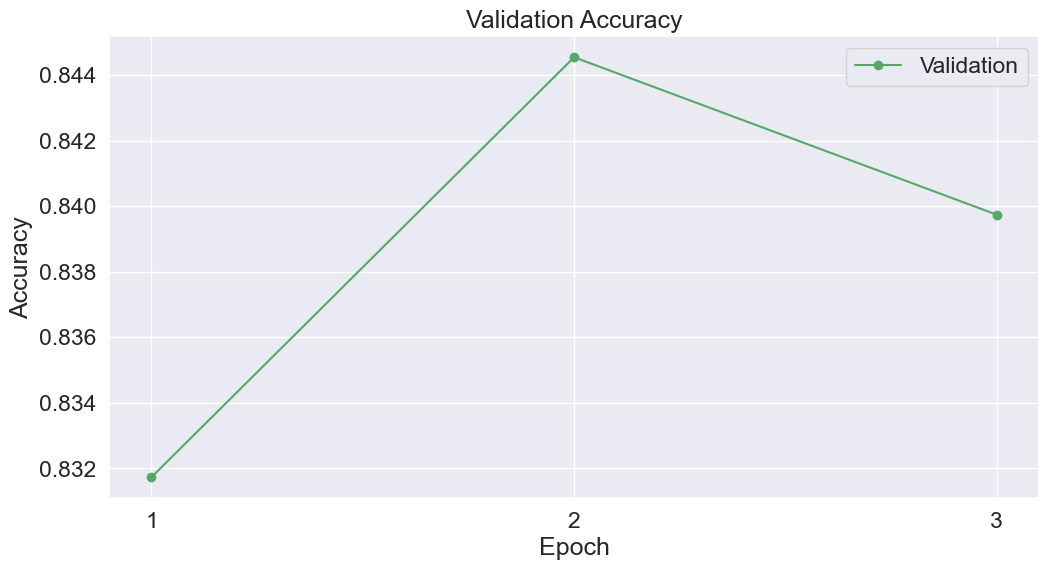

In [91]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

**4. Performance On Test Set**

**4.1. Data preparation**

In [ ]:
# Test
# tweets_test = test_ds.clean_text.values
# labels_test = test_ds.target.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for tweet in tweets_test:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 64  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

**4.2. Evaluate on test set**

In [43]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels_test = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_test_ids = b_labels_test.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_test_ids)

print('    DONE.')

Predicting labels for 1,523 test sentences...
    DONE.


In [93]:
from sklearn.metrics import f1_score

f1_set = []
y_preds, y_trues = [], []

# Evaluate each test batch using f1_score
print('Calculating f1 score for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  y_preds.append(pred_labels_i)
  y_trues.append(true_labels[i])
  
  # Calculate and store the coef for this batch.  
  f1 = f1_score(true_labels[i], pred_labels_i)
  #print(f1)                
  f1_set.append(f1)

Calculating f1 score. for each batch...
0.8333333333333334
0.7636363636363638
0.7272727272727272
0.8070175438596492
0.8196721311475409
0.7843137254901961
0.819672131147541
0.84
0.84375
0.7826086956521738
0.8285714285714285
0.8085106382978724
0.8148148148148148
0.7755102040816326
0.7796610169491526
0.7540983606557378
0.816326530612245
0.7999999999999999
0.8421052631578947
0.8
0.75
0.7843137254901961
0.6666666666666666
0.7391304347826088


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_20284\2542193774.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(f1_set))), y=f1_set, ci=None)


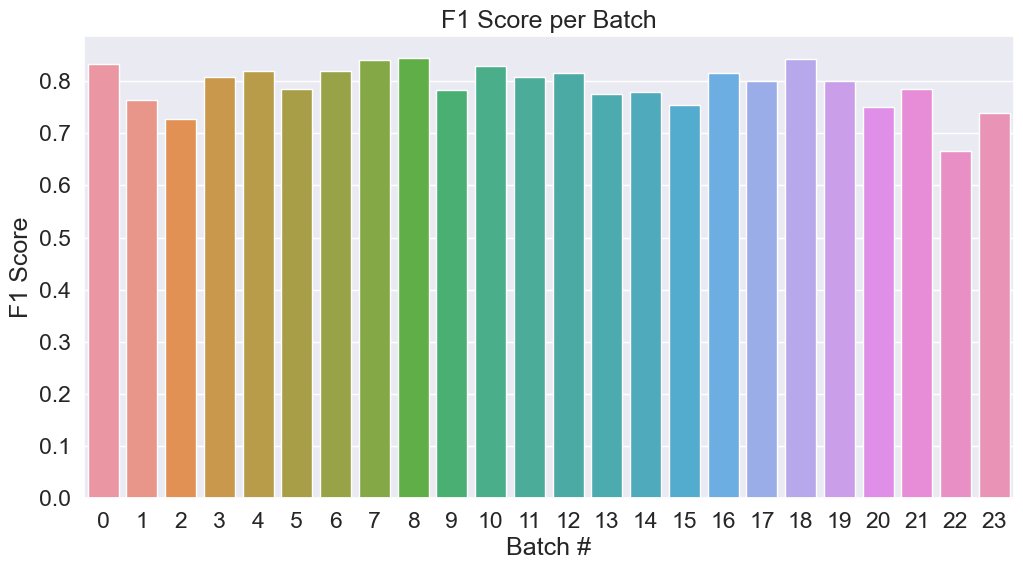

In [94]:
# Create a barplot showing the f1 score for each batch of test samples
ax = sns.barplot(x=list(range(len(f1_set))), y=f1_set, ci=None)

plt.title('F1 Score per Batch')
plt.ylabel('F1 Score')
plt.xlabel('Batch #')

plt.show()

In [96]:
# Combine the results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate F1 score
f1 = f1_score(flat_true_labels, flat_predictions)

print('Total f1 score: %.3f' % f1)

Total MCC: 0.637
Total f1 score: 0.793


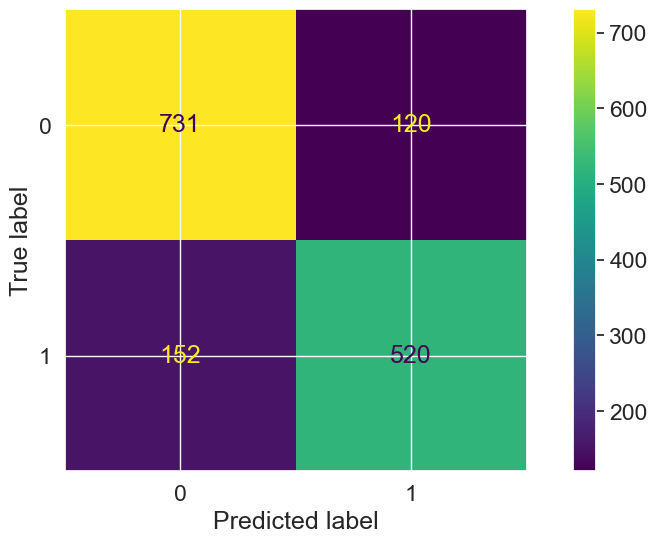

              precision    recall  f1-score   support

           0      0.828     0.859     0.843       851
           1      0.812     0.774     0.793       672

    accuracy                          0.821      1523
   macro avg      0.820     0.816     0.818      1523
weighted avg      0.821     0.821     0.821      1523



In [100]:
#Confusion matrix BERT
cm=confusion_matrix(flat_true_labels, flat_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(flat_true_labels, flat_predictions, digits=3))

In [101]:
# saving&loading model
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))




Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')